# Installing Dependencies

In [25]:
#install libraries for colab compatability
!pip install pandas numpy scikit-learn ucimlrepo


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Downloading Dataset/Describing Variables

In [26]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
student_performance = fetch_ucirepo(id=320)

# data (as pandas dataframes)
X = student_performance.data.features
y = student_performance.data.targets

# metadata
print(student_performance.metadata)

# variable information
print(student_performance.variables)

{'uci_id': 320, 'name': 'Student Performance', 'repository_url': 'https://archive.ics.uci.edu/dataset/320/student+performance', 'data_url': 'https://archive.ics.uci.edu/static/public/320/data.csv', 'abstract': 'Predict student performance in secondary education (high school). ', 'area': 'Social Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 649, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': ['Sex', 'Age', 'Other', 'Education Level', 'Occupation'], 'target_col': ['G1', 'G2', 'G3'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5TG7T', 'creators': ['Paulo Cortez'], 'intro_paper': {'ID': 360, 'type': 'NATIVE', 'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'venue': 'Proceedings of 5th Annual Future Business Technolo

# Cleaning Data

In [27]:
import pandas as pd

# check missing values
print("Missing values per column: ")
print(X.isna().sum())

# drop duplicates
X = X.drop_duplicates()
y = y.loc[X.index]

# drop G1 and G2 to avoid target leakage, as these are just the semester grades that make up final grade
if {"G1","G2"}.issubset(X.columns):
    X = X.drop(columns=["G1","G2"])

# drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# convert yes/no columns to 0/1
binary_cols = ["schoolsup","famsup","paid","activities","nursery",
               "higher","internet","romantic"]
for col in binary_cols:
    if col in X.columns:
        X[col] = X[col].map({"yes": 1, "no": 0})

# convert simple ordinal categories (LE3 is confusing for example)
if "famsize" in X.columns:
    X["famsize"] = X["famsize"].map({"LE3": 0, "GT3": 1})
if "address" in X.columns:
    X["address"] = X["address"].map({"U": 1, "R": 0})

# clip outliers in absences (some are abnormally high at > 100)
if "absences" in X.columns:
    X["absences"] = X["absences"].clip(upper=40)

# group rare job categories to limit number of categorical values
job_cols = ["Mjob","Fjob"]
for col in job_cols:
    if col in X.columns:
        counts = X[col].value_counts()
        rare = counts[counts < 10].index
        X[col] = X[col].replace(rare, "other")

# group rare "reason" and "guardian" categories to limit number of categorical values
rare_group_cols = ["reason","guardian"]
for col in rare_group_cols:
    if col in X.columns:
        counts = X[col].value_counts()
        rare = counts[counts < 10].index
        X[col] = X[col].replace(rare, "other")

# one-hot encode remaining categoricals
X = pd.get_dummies(X, drop_first=True)

# check zero-variance columns
zero_var = X.columns[X.nunique() <= 1]
print("Zero variance columns:", list(zero_var))

# realign y after all X cleaning
y = y.loc[X.index]

# scale numeric values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train/test 80/20 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


Missing values per column: 
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
dtype: int64
Zero variance columns: []


# Training KNN Model

In [28]:
# run kNN with a variety of K values
from sklearn.neighbors import KNeighborsRegressor

k_values = [1, 3, 5, 7, 9, 11, 15, 21,35,42,50]

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    print(f"k={k} predictions (first 10): {preds[:10]}")

k=1 predictions (first 10): [[16. 14. 14.]
 [15. 16. 17.]
 [15. 14. 15.]
 [15. 16. 17.]
 [13. 14. 13.]
 [13. 14. 14.]
 [14. 14. 14.]
 [ 4.  8.  8.]
 [11. 12. 12.]
 [12. 12. 12.]]
k=3 predictions (first 10): [[15.         14.         14.66666667]
 [13.33333333 14.         15.66666667]
 [13.66666667 13.33333333 14.33333333]
 [12.         12.33333333 13.66666667]
 [12.33333333 12.66666667 12.33333333]
 [14.33333333 14.66666667 15.33333333]
 [16.         16.33333333 16.33333333]
 [ 8.         11.         11.33333333]
 [12.33333333 11.66666667 12.        ]
 [10.66666667 11.         11.33333333]]
k=5 predictions (first 10): [[13.6 13.2 13.8]
 [13.4 14.6 15.8]
 [14.2 14.2 14.8]
 [13.2 13.  14.2]
 [12.  12.2 12.2]
 [13.8 13.8 14.4]
 [13.4 14.2 14.2]
 [ 8.6 10.2 10.4]
 [13.6 13.4 13.8]
 [11.4 11.8 12. ]]
k=7 predictions (first 10): [[13.71428571 13.71428571 14.28571429]
 [12.71428571 13.28571429 14.28571429]
 [14.28571429 14.         14.42857143]
 [12.57142857 12.28571429 13.28571429]
 [11.5714

KNN Results

In [29]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Evaluate kNN on the final grade G3 to match advanced models
target_col = "G3" if "G3" in y_train.columns else y_train.columns[-1]
target_idx = list(y_train.columns).index(target_col)

knn_results = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)

    # use only the G3 (final grade) column for evaluation
    y_true = y_test[target_col].values
    preds_target = preds[:, target_idx]

    mse = mean_squared_error(y_true, preds_target)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, preds_target)

    knn_results.append((k, rmse, r2))
    print(f"k={k}: RMSE={rmse:.3f}, R-squared={r2:.3f}")

# Results in DataFrame
knn_results_df = pd.DataFrame(knn_results, columns=["k", "RMSE", "R2"])
display(knn_results_df)

# Select k with the lowest RMSE
best_idx = knn_results_df["RMSE"].idxmin()
best_row = knn_results_df.loc[best_idx]

best_k = best_row["k"]
knn_rmse = best_row["RMSE"]
knn_r2 = best_row["R2"]

print(f"\nBest kNN model: k={best_k:.0f}, RMSE={knn_rmse:.3f}, R-squared={knn_r2:.3f}")

k=1: RMSE=3.729, R-squared=-0.426
k=3: RMSE=3.195, R-squared=-0.047
k=5: RMSE=3.024, R-squared=0.063
k=7: RMSE=2.897, R-squared=0.139
k=9: RMSE=2.880, R-squared=0.150
k=11: RMSE=2.912, R-squared=0.130
k=15: RMSE=2.892, R-squared=0.142
k=21: RMSE=2.844, R-squared=0.170
k=35: RMSE=2.840, R-squared=0.173
k=42: RMSE=2.858, R-squared=0.162
k=50: RMSE=2.871, R-squared=0.155


,k,RMSE,R2
0,1,3.729302,-0.426179
1,3,3.194948,-0.046759
2,5,3.023549,0.062540
3,7,2.896921,0.139418
4,9,2.879620,0.149666
5,11,2.912280,0.130269
6,15,2.892365,0.142122
7,21,2.844140,0.170491
8,35,2.840148,0.172818
9,42,2.857992,0.162392



Best kNN model: k=35, RMSE=2.840, R-squared=0.173


# Complex Models

According to our feedback, we want to add additional models that are more complex than kNN and analyze their relative success. Potential advanced models we will use are Decision Tree, Random Forest, Gradient Boosting, Bagging, and Lasso.

Model Prep

In [30]:
# Target for regression (final grade G3)
if "G3" in y.columns:
    y_target = y["G3"]
else:
    # use last column if names differ
    y_target = y.iloc[:, -1]

Split for advanced models

In [31]:
from sklearn.model_selection import train_test_split

# New split for advanced models (keeps X as a DataFrame)
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X, y_target, test_size=0.2, random_state=42
)

Preprocessing for advanced models

In [32]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(exclude=['int64', 'float64']).columns

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

Decision Tree Regressor

In [33]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

tree_model = Pipeline(steps=[
    ('prep', preprocess),
    ('model', DecisionTreeRegressor(random_state=42))
])

tree_model.fit(X_train_adv, y_train_adv)
tree_preds = tree_model.predict(X_test_adv)

tree_mse = mean_squared_error(y_test_adv, tree_preds)
tree_rmse = np.sqrt(tree_mse)
tree_r2 = r2_score(y_test_adv, tree_preds)

print("Decision Tree RMSE:", tree_rmse)
print("Decision Tree R-squared:", tree_r2)

Decision Tree RMSE: 3.79675975212873
Decision Tree R-squared: -0.47824081939758756


Random Forest Regressor

In [34]:
from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline(steps=[
    ('prep', preprocess),
    ('model', RandomForestRegressor(
        n_estimators=300,
        random_state=42
    ))
])

rf_model.fit(X_train_adv, y_train_adv)
rf_preds = rf_model.predict(X_test_adv)

rf_mse = mean_squared_error(y_test_adv, rf_preds)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test_adv, rf_preds)

print("Random Forest RMSE:", rf_rmse)
print("Random Forest R-squared:", rf_r2)

Random Forest RMSE: 2.821211869083286
Random Forest R-squared: 0.1838117076446364


Gradient Boosting Regressor

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = Pipeline(steps=[
    ('prep', preprocess),
    ('model', GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

gb_model.fit(X_train_adv, y_train_adv)
gb_preds = gb_model.predict(X_test_adv)

gb_mse = mean_squared_error(y_test_adv, gb_preds)
gb_rmse = np.sqrt(gb_mse)
gb_r2 = r2_score(y_test_adv, gb_preds)

print("Gradient Boosting RMSE:", gb_rmse)
print("Gradient Boosting R-squared:", gb_r2)

Gradient Boosting RMSE: 2.770553858977834
Gradient Boosting R-squared: 0.21285969524466186


Bagging Regressor

In [36]:
from sklearn.ensemble import BaggingRegressor

bag_model = Pipeline(steps=[
    ('prep', preprocess),
    ('model', BaggingRegressor(
        n_estimators=100,
        random_state=42
    ))
])

bag_model.fit(X_train_adv, y_train_adv)
bag_preds = bag_model.predict(X_test_adv)

bag_mse = mean_squared_error(y_test_adv, bag_preds)
bag_rmse = np.sqrt(bag_mse)
bag_r2 = r2_score(y_test_adv, bag_preds)

print("Bagging RMSE:", bag_rmse)
print("Bagging R-squared:", bag_r2)

Bagging RMSE: 2.8513807721334423
Bagging R-squared: 0.1662623965437734


Lasso Regression

In [37]:
from sklearn.linear_model import Lasso

lasso_model = Pipeline(steps=[
    ('prep', preprocess),
    ('model', Lasso(alpha=0.01))
])

lasso_model.fit(X_train_adv, y_train_adv)
lasso_preds = lasso_model.predict(X_test_adv)

lasso_mse = mean_squared_error(y_test_adv, lasso_preds)
lasso_rmse = np.sqrt(lasso_mse)
lasso_r2 = r2_score(y_test_adv, lasso_preds)

print("Lasso RMSE:", lasso_rmse)
print("Lasso R-squared:", lasso_r2)

Lasso RMSE: 2.8179671909614123
Lasso R-squared: 0.18568802571684706


Advanced Model Comparison

In [38]:
comparison = pd.DataFrame({
    "Model": [
        "kNN (best k)",
        "Decision Tree",
        "Random Forest",
        "Gradient Boosting",
        "Bagging",
        "Lasso"
    ],
    "RMSE": [
        knn_rmse,
        tree_rmse,
        rf_rmse,
        gb_rmse,
        bag_rmse,
        lasso_rmse
    ],
    "R_squared": [
        knn_r2,
        tree_r2,
        rf_r2,
        gb_r2,
        bag_r2,
        lasso_r2
    ]
})

comparison

,Model,RMSE,R_squared
0,kNN (best k),2.840148,0.172818
1,Decision Tree,3.796760,-0.478241
2,Random Forest,2.821212,0.183812
3,Gradient Boosting,2.770554,0.212860
4,Bagging,2.851381,0.166262
5,Lasso,2.817967,0.185688


We can conclude that the best model with the lowest RMSE and highest R-squared is Gradient Boosting with an RMSE of 2.770554 and an R-squared of 0.212860. The second best model would be Lasso, then Random Forest, and then kNN. The R-squared values are not particularly strong.


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


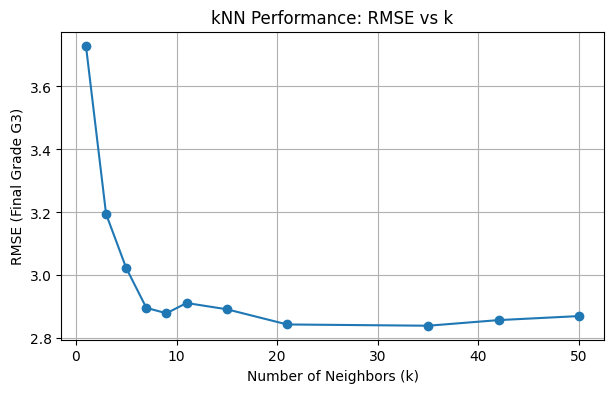

In [39]:
!pip install matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(knn_results_df["k"], knn_results_df["RMSE"], marker="o")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("RMSE (Final Grade G3)")
plt.title("kNN Performance: RMSE vs k")
plt.grid(True)
plt.show()

As k increases RMSE drops and then levels off around the 21-35 range. This highlights that very small k values overfit while moderate k values give more stable, accurate predictions.

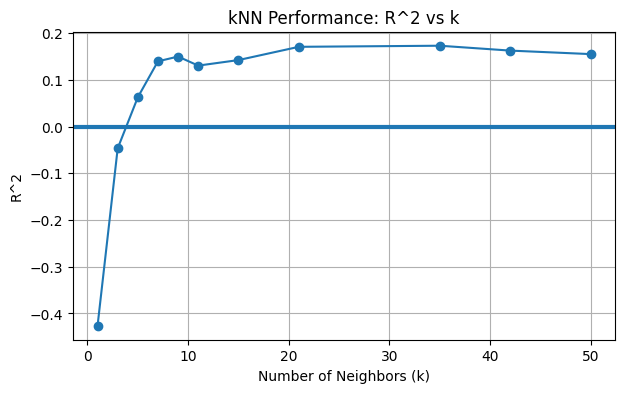

In [40]:
#kNN Validation: R^2 vs K
plt.figure(figsize=(7,4))
plt.plot(knn_results_df["k"], knn_results_df["R2"], marker="o")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("R^2")
plt.title("kNN Performance: R^2 vs k")
plt.axhline(0, linewidth=3)
plt.grid(True)
plt.show()

R^2 is negative at k=1, which is worse than predicting the mean, but increases around k=20-35, showing that the tuned kNN model is only modestly better than the baseline but better than a small k.

In [41]:
# Model Comparision: RMSE
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Baseline predict mean training G3
baseline_predict = np.full_like(y_test_adv, fill_value=y_train_adv.mean(), dtype=float)
baseline_rmse = np.sqrt(mean_squared_error(y_test_adv, baseline_predict))
baseline_r2 = r2_score(y_test_adv, baseline_predict)

baseline_row = {
    "Model": "Baseline (Mean G3)",
    "RMSE": baseline_rmse,
    "R_squared": baseline_r2
}

comparison_with_base = pd.concat(
    [pd.DataFrame([baseline_row]), comparison],
    ignore_index=True
)

comparison_rmse_sorted = comparison_with_base.sort_values("RMSE").reset_index(drop=True)
comparison_rmse_sorted

,Model,RMSE,R_squared
0,Gradient Boosting,2.770554,0.212860
1,Lasso,2.817967,0.185688
2,Random Forest,2.821212,0.183812
3,kNN (best k),2.840148,0.172818
4,Bagging,2.851381,0.166262
5,Baseline (Mean G3),3.172590,-0.032160
6,Decision Tree,3.796760,-0.478241


Gradient bosting has the lowest RMSE with 2.77, followed by Lasso, Random Forest, and kNN. These all beat the baseline which was 3.17, while the Decision Tree is last having a RMSE of 3.80.

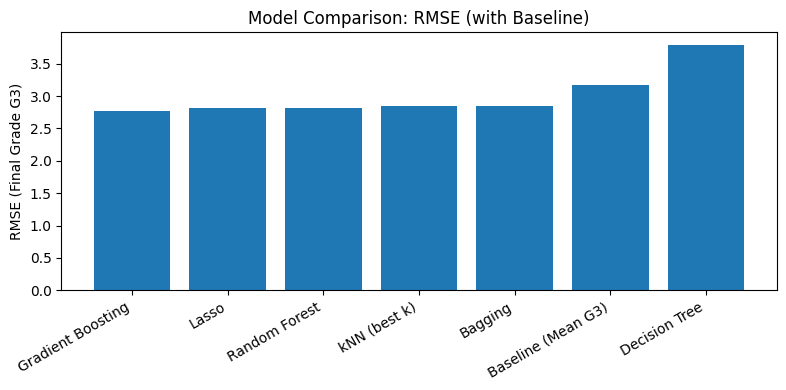

In [42]:
# Plotting RMSE
plt.figure(figsize=(8,4))
plt.bar(comparison_rmse_sorted["Model"], comparison_rmse_sorted["RMSE"])
plt.ylabel("RMSE (Final Grade G3)")
plt.title("Model Comparison: RMSE (with Baseline)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

The baseline model has the highest RMSE, while Gradient Boosting achieves the lowest RMSE. This shows the all ML model models beat a naive mean predictor, and Gradient Boosting makes the most accurate predictions overall.

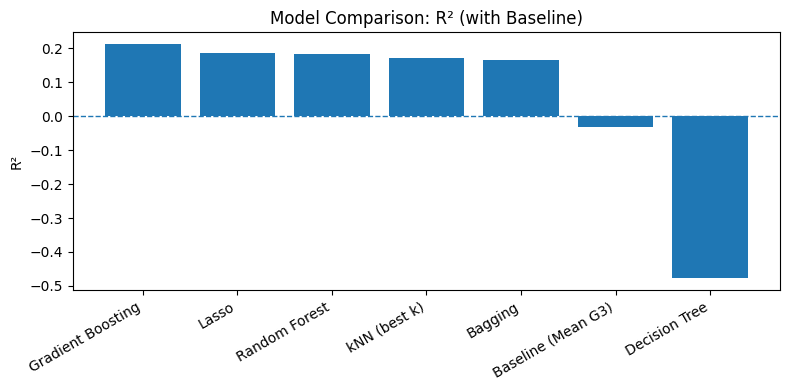

In [43]:
# Model comparision: R^2 including baseline
comparison_r2_sorted = comparison_with_base.sort_values("R_squared", ascending=False).reset_index(drop=True)

plt.figure(figsize=(8,4))
plt.bar(comparison_r2_sorted["Model"], comparison_r2_sorted["R_squared"])
plt.ylabel("R²")
plt.title("Model Comparison: R² (with Baseline)")
plt.axhline(0, linestyle="--", linewidth=1)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

Gradient Boosting has the highest R^2, followed by Random Forest and Lasso, while the baseline sits at near zero. Though R^2 values are modest, the decision-based ensables show more variance than the baseline and simpler models.

Gradient Boosting CV RMSE (per fold): [2.85919576 2.94051088 3.0806148  2.7436918  2.52206239]
Mean CV RMSE: 2.8292151231519846
Std CV RMSE: 0.18875615120411215


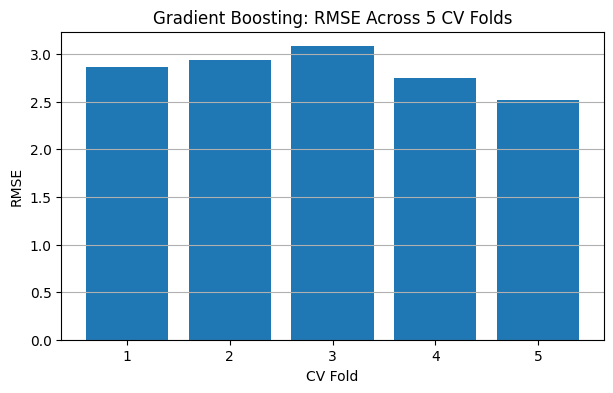

In [44]:
# Cross validating for Gradient Boosting
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

gb_cv_neg_mse = cross_val_score(
    gb_model,
    X_train_adv,
    y_train_adv,
    cv=5,
    scoring="neg_mean_squared_error"
)

gradient_boost_cv_rmse = np.sqrt(-gb_cv_neg_mse)
print("Gradient Boosting CV RMSE (per fold):", gradient_boost_cv_rmse)
print("Mean CV RMSE:", gradient_boost_cv_rmse.mean())
print("Std CV RMSE:", gradient_boost_cv_rmse.std())

plt.figure(figsize=(7,4))
plt.bar(range(1, len(gradient_boost_cv_rmse)+1), gradient_boost_cv_rmse)
plt.xlabel("CV Fold")
plt.ylabel("RMSE")
plt.title("Gradient Boosting: RMSE Across 5 CV Folds")
plt.xticks(range(1, len(gradient_boost_cv_rmse)+1))
plt.grid(True, axis="y")
plt.show()

RMSE is similar across the five folds, with a small spread around the mean. This indicates that Gradient Boostings performance is stable and not overly sensitive to how the data is split.

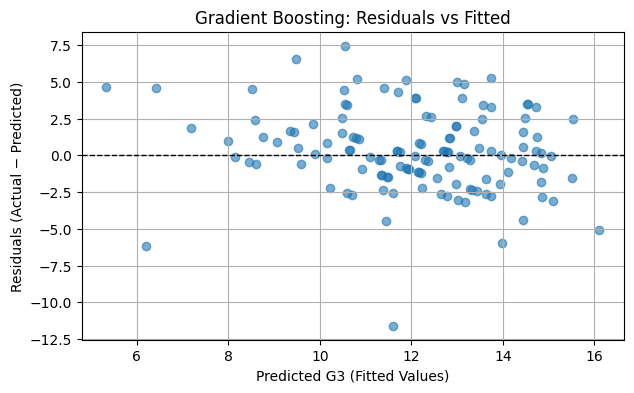

In [45]:
# Residuals vs Gradient Boosting
gb_preds = gb_model.predict(X_test_adv)
residuals = y_test_adv - gb_preds

plt.figure(figsize=(7,4))
plt.scatter(gb_preds, residuals, alpha=0.6)
plt.axhline(0, linestyle="--", linewidth=1, color="black")
plt.xlabel("Predicted G3 (Fitted Values)")
plt.ylabel("Residuals (Actual − Predicted)")
plt.title("Gradient Boosting: Residuals vs Fitted")
plt.grid(True)
plt.show()

The residuals are roughly centered around zero across the range of predicted grades, with no extreme or sharp funnel shape. This suggest that the model is roughly unbaised.

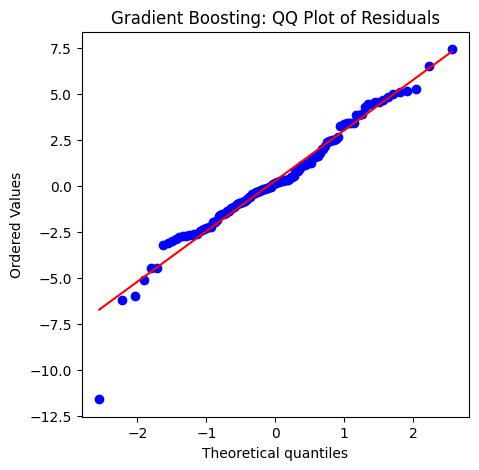

In [46]:
# QQ Plot of Residuals - Gradient Boosting
import scipy.stats as stats

plt.figure(figsize=(5,5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Gradient Boosting: QQ Plot of Residuals")
plt.show()

Most of the residuals fall closely to the straight line int he QQ plot with few deviation within the tail end. This shows indication that residuals are relatively normal.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

prep = gb_model.named_steps["prep"]
gb = gb_model.named_steps["model"]

feature_names = prep.get_feature_names_out()

importances = gb.feature_importances_

gb_importances = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

gb_importances.head(15)


,feature,importance
0,num__failures,0.251446
1,num__absences,0.059454
2,num__Dalc,0.057034
3,num__higher,0.042789
4,cat__school_MS_False,0.041524
5,num__Fedu,0.038310
6,num__age,0.034991
7,num__goout,0.034703
8,num__Medu,0.031613
9,num__Walc,0.030404


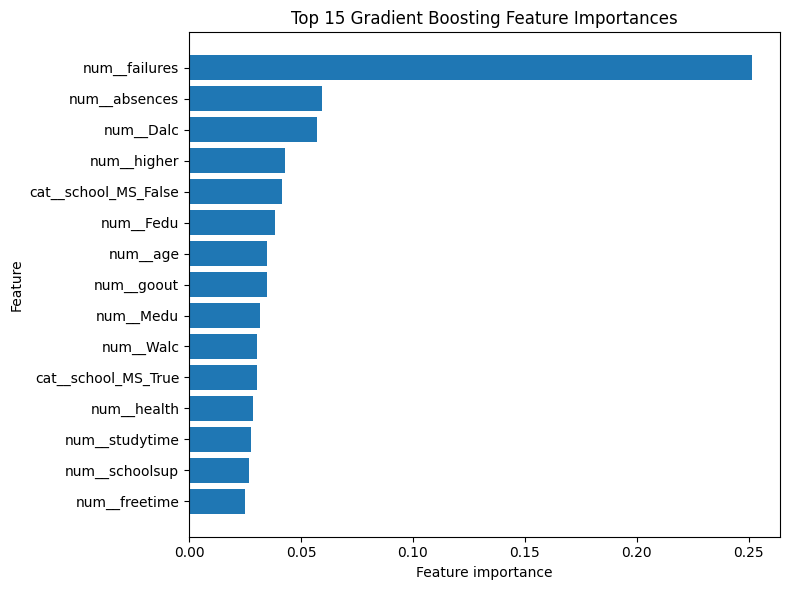

In [48]:
top_n = 15
top_imp = gb_importances.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Gradient Boosting Feature Importances")
plt.tight_layout()
plt.show()
